In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
import xarray as xr

from shapely.affinity import translate
from shapely.geometry import LineString, Point, Polygon
from shapely.ops import substring

### Tests with arbitrary geometry

In [180]:
width = 1
height = 5

In [167]:
# Test nadir track
nadir = LineString([[-1,-5], [4,10]])

In [168]:
# Test pixel centroid
pixel = Point([2,2])

In [169]:
pixel.coords[0]

(2.0, 2.0)

In [170]:
# Get distance along nadir track closest to pixel centroid
dist = nadir.project(pixel)

In [171]:
dist

np.float64(7.58946638440411)

In [172]:
# Get coordinate of point along nadir closest to pixel centroid
projection = substring(nadir, 0, dist).coords[1]

In [173]:
# Create linestring from pixel to closest point on nadir track
orthogonal = LineString([pixel.coords[0], projection])

In [174]:
# Get left midpoint
left_mid_coord = substring(orthogonal, 0, width/2).coords[1]
left_mid_pt = Point(left_mid_coord)

In [175]:
# Get distance for translation form nadir
mid_dist = orthogonal.length - width/2

In [176]:
left_edge = nadir.parallel_offset(distance=mid_dist, side='right')
right_edge = nadir.parallel_offset(distance=mid_dist+width, side='right')

In [177]:
# Get right midpoint
right_dist = right_edge.project(pixel)
right_mid_coord = substring(right_edge, 0, right_dist).coords[1]
right_mid_pt = Point(right_mid_coord)

In [193]:
one_coord = substring(left_edge, dist, dist+height/2).coords[1]
one_pt = Point(one_coord)

two_coord = substring(right_edge, dist, dist+height/2).coords[1]
two_pt = Point(two_coord)

three_coord = substring(right_edge, dist-height/2, dist).coords[0]
three_pt = Point(three_coord)

four_coord = substring(left_edge, dist-height/2, dist).coords[0]
four_pt = Point(four_coord)

In [203]:
pseudo_pixel = Polygon((one_coord, two_coord, three_coord, four_coord, one_coord))

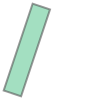

In [205]:
pseudo_pixel

In [151]:
# left_edge = translate(geom=nadir, xoff=edge_dist, yoff=edge_dist)
# right_edge = translate(geom=nadir, xoff=edge_dist+width, yoff=edge_dist+width)
# left_gs = gpd.GeoSeries(left_edge)

<Axes: >

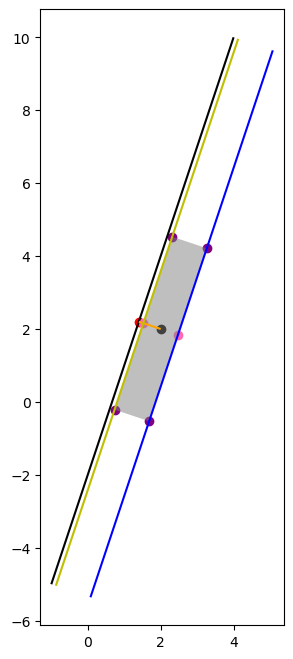

In [199]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(nadir).plot(ax=ax, color='k')
gpd.GeoSeries(pixel).plot(ax=ax, color='k')

gpd.GeoSeries(Point(projection)).plot(ax=ax, color='r')
gpd.GeoSeries(orthogonal).plot(ax=ax, color='orange')
gpd.GeoSeries(left_mid_pt).plot(ax=ax, color='hotpink')
gpd.GeoSeries(right_mid_pt).plot(ax=ax, color='hotpink')

gpd.GeoSeries(right_edge).plot(ax=ax, color='b')
gpd.GeoSeries(left_edge).plot(ax=ax, color='y')

gpd.GeoSeries(one_pt).plot(ax=ax, color='purple')
gpd.GeoSeries(two_pt).plot(ax=ax, color='purple')
gpd.GeoSeries(three_pt).plot(ax=ax, color='purple')
gpd.GeoSeries(four_pt).plot(ax=ax, color='purple')

gpd.GeoSeries(pseudo_pixel).plot(ax=ax, color='grey', alpha=0.5)

### With actual SWOT data

#### Pixel Cloud

In [2]:
def bitwiseMask(ds):
    # Fow now, eliminate the really bad stuff
    mask = np.where((ds.classification > 2) & (ds.geolocation_qual < 2**16) &
                    (np.abs(ds.cross_track) > 10000) & (np.abs(ds.cross_track) < 60000))[0]
    
    print(mask.shape)
    return mask

In [3]:
def makeGDF(ds, mask, data_vars):
    '''
    This function takes the pixel cloud xarray object, makes a masked
    GeoDataFrame, renames columns as needed, set the CRS, reprojects
    the CRS, and returns a GeoDataFrame.
    '''
    # Subset xarray, convert to masked DataFrame
    xarr = ds[data_vars]
    df = xarr.to_dataframe().loc[mask].reset_index()

    # Create GDF
    gdf_PIXC = gpd.GeoDataFrame(df,
                                geometry=gpd.points_from_xy(df.longitude,
                                                            df.latitude),
                                crs="EPSG:4326") # PIXC has no native CRS, setting same as River_SP

    if 'classification' in gdf_PIXC.columns:
        gdf_PIXC.rename(columns={'classification': 'klass'}, inplace=True)
    
    # Convert the crs to WGS 84 / Pseudo-Mercator
    gdf_PIXC = gdf_PIXC.to_crs(epsg=3857)
    
    return gdf_PIXC

In [4]:
leaf_off = '../data/small_rivers/mar_2024_ver_c/SWOT_L2_HR_PIXC_012_298_080L_20240317T084237_20240317T084248_PIC0_01.nc'

In [5]:
# Read in xarray
ds_PIXC = xr.open_mfdataset(paths=leaf_off, group = 'pixel_cloud', engine='h5netcdf')

In [150]:
# ds_PIXC

In [6]:
# Read in xarray
ds_GLOB = xr.open_mfdataset(paths=leaf_off, engine='h5netcdf')

In [149]:
# ds_GLOB

In [7]:
pass_num = ds_GLOB.pass_number
pass_num

np.int16(298)

In [8]:
# Make dict for legend labels
flags = ds_PIXC.classification.flag_meanings.split() # extract each flag meaning
codes = {idx:k for idx, k in enumerate(flags, start=1)}

In [9]:
# Make mask
mask = bitwiseMask(ds_PIXC)

(887993,)


In [10]:
variables = ['azimuth_index', 'range_index', 'cross_track',
             'pixel_area', 'classification']

In [12]:
# If dataframe not empty after filtering
if mask.shape != (0,):
    # Make PIXC
    gdf_PIXC = makeGDF(ds=ds_PIXC, mask=mask, data_vars=variables)
    # # Append to list
    # d.append(gdf_PIXC)

In [13]:
gdf_PIXC

,points,azimuth_index,range_index,cross_track,pixel_area,klass,latitude,longitude,geometry
0,401,160.0,1024.0,-10889.750977,1178.953125,6.0,42.677126,-72.876377,POINT (-8112561.231 5262955.498)
1,454,160.0,1191.0,-19793.564453,649.818542,3.0,42.695743,-72.774072,POINT (-8101172.608 5265774.829)
2,494,160.0,1255.0,-19913.406250,645.948059,3.0,42.696196,-72.771573,POINT (-8100894.448 5265843.516)
3,495,160.0,1256.0,-20000.214844,643.149109,3.0,42.696374,-72.770593,POINT (-8100785.347 5265870.449)
4,496,160.0,1257.0,-20060.488281,641.220032,3.0,42.696443,-72.770210,POINT (-8100742.721 5265880.971)
...,...,...,...,...,...,...,...,...,...
887988,6424016,3105.0,3772.0,-58681.511719,219.810181,4.0,42.217827,-72.130669,POINT (-8029549.384 5193664.943)
887989,6424017,3105.0,3773.0,-58691.574219,219.772675,4.0,42.217847,-72.130554,POINT (-8029536.537 5193668.001)
887990,6424018,3105.0,3774.0,-58701.718750,219.734879,3.0,42.217915,-72.130169,POINT (-8029493.671 5193678.196)
887991,6424036,3105.0,3792.0,-58883.796875,219.058853,3.0,42.218353,-72.127685,POINT (-8029217.216 5193743.953)


In [14]:
pixel = gdf_PIXC.sample(n=1, random_state=0)

In [15]:
pixel

,points,azimuth_index,range_index,cross_track,pixel_area,klass,latitude,longitude,geometry
393641,3696112,1985.0,3129.0,-50703.476562,254.252487,4.0,42.414495,-72.293195,POINT (-8047641.633 5223272.432)


In [16]:
pixel_pt = pixel.geometry[pixel.index[0]]

#### Nadir

In [19]:
height = 22

In [74]:
width = pixel.pixel_area[pixel.index[0]]/height

In [75]:
width

np.float32(11.5569315)

In [20]:
nadir = gpd.read_file('/nas/cee-water/cjgleason/data/SWOT/swath/swot_science_hr_Aug2021-v05_shapefile_nadir/swot_science_hr_2.0s_4.0s_Aug2021-v5_nadir.shp')

In [21]:
nadir.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [22]:
# Convert the crs to WGS 84 / Pseudo-Mercator
nadir = nadir.to_crs(epsg=3857)

In [23]:
nadir

,ID_SEG,ID_PASS,START_TIME,geometry
0,1,1,Day 01 00:27:16,"LINESTRING (103762.456 580191.408, 107238.852 ..."
1,2,1,Day 01 00:35:46,"LINESTRING (692810.209 4065036.58, 699081.281 ..."
2,3,1,Day 01 00:36:05,"LINESTRING (723478.84 4212061.88, 731273.431 4..."
3,4,1,Day 01 00:37:53,"LINESTRING (917976.255 5074726.98, 931863.25 5..."
4,5,1,Day 01 00:38:44,"LINESTRING (1026986.423 5510945.659, 1039343.1..."
...,...,...,...,...
2865,2866,583,Day 21 19:40:59,"LINESTRING (3935337.584 5611680.267, 3936249.6..."
2866,2867,583,Day 21 19:41:30,"LINESTRING (4008452.56 5883159.397, 4033022.44..."
2867,2868,583,Day 21 19:53:05,"LINESTRING (11469481.798 14146679.712, 1159583..."
2868,2869,584,Day 21 19:58:07,"LINESTRING (18027273.259 11006065.269, 1805432..."


In [25]:
# subset = nadir[nadir['ID_PASS'] == pass_num]
subset = nadir[nadir['ID_SEG'] == 1466]

In [26]:
subset_ln = subset.geometry[subset.index[0]]

<Axes: >

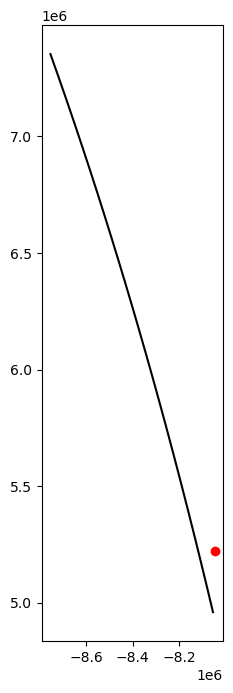

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(subset_ln).plot(ax=ax, color='k')
gpd.GeoSeries(pixel_pt).plot(ax=ax, color='r')

In [28]:
# Get distance along nadir track closest to pixel centroid
dist = subset_ln.project(pixel_pt)

In [142]:
dist

np.float64(2243857.5270774695)

In [32]:
# Get coordinate of point along nadir closest to pixel centroid
projection = substring(subset_ln, dist, 0).coords[1]

In [33]:
# Create linestring from pixel to closest point on nadir track
orthogonal = LineString([pixel_pt.coords[0], projection])

In [57]:
up = orthogonal.parallel_offset(distance=height/2, side='right')
down = orthogonal.parallel_offset(distance=height/2, side='left')

In [81]:
# Get coords for inner edge
one_coord = substring(up, start_dist=0, end_dist=width/2).coords[1]
two_coord = substring(down, start_dist=0, end_dist=width/2).coords[1]

In [83]:
inner_edge = LineString([two_coord, one_coord])

In [105]:
outer_edge = inner_edge.parallel_offset(distance=width, side='right')

In [110]:
three_coord = outer_edge.coords[0]
four_coord = outer_edge.coords[1]

In [111]:
pseudo_pixel = Polygon((one_coord, two_coord, three_coord, four_coord, one_coord))

(5223200.0, 5223325.0)

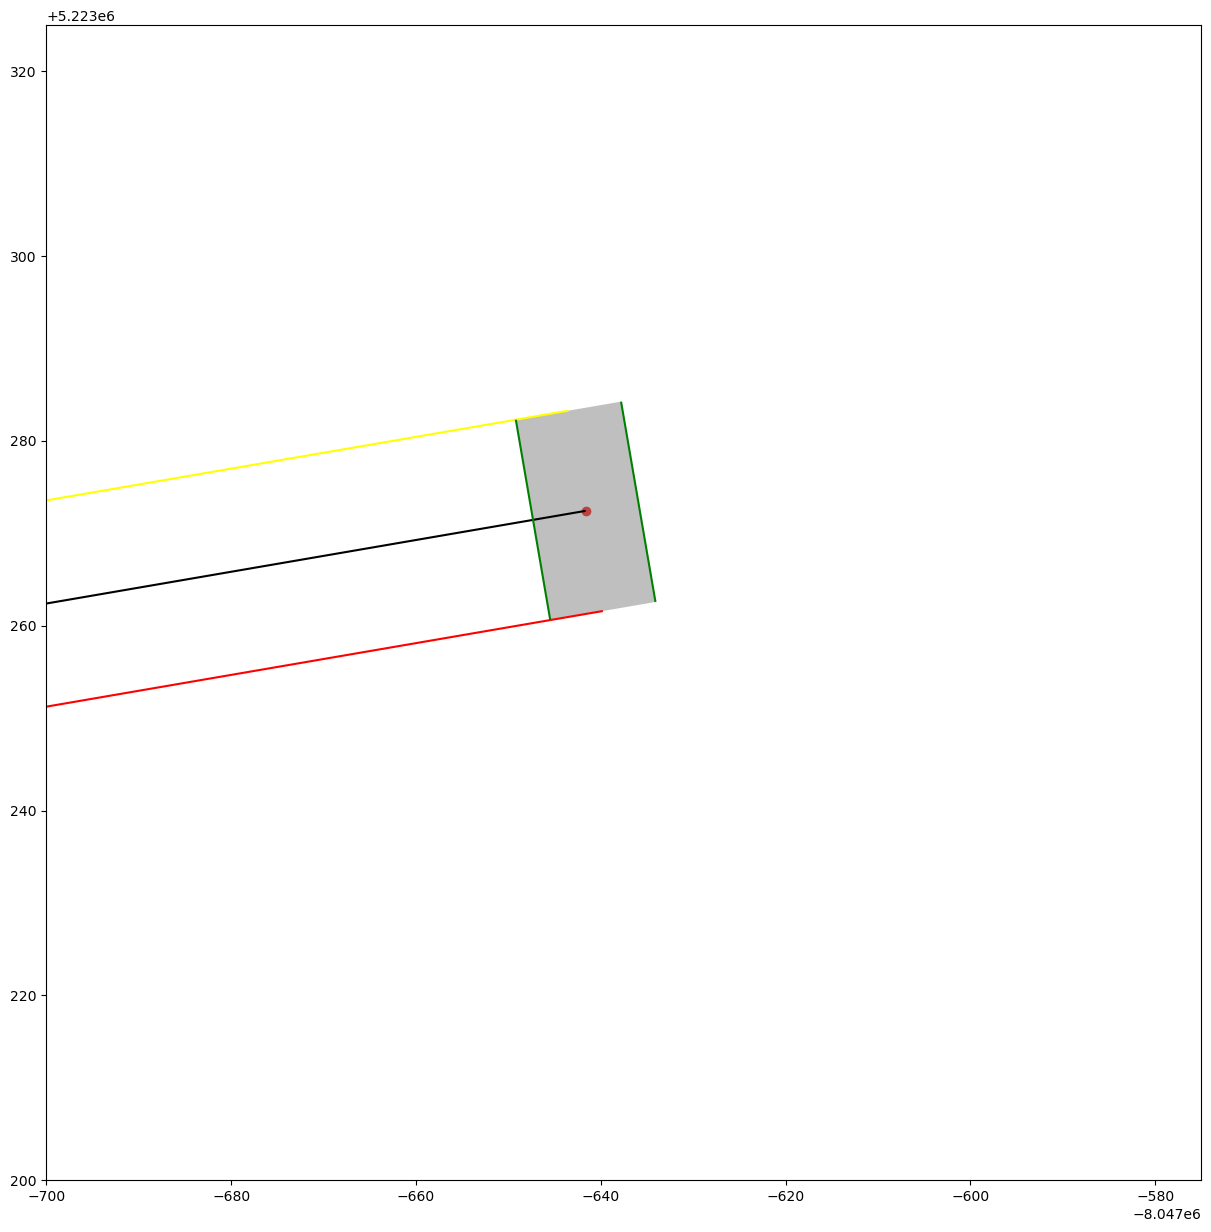

In [112]:
fig, ax = plt.subplots(figsize=(15,15))
gpd.GeoSeries(subset_ln).plot(ax=ax, color='k')
gpd.GeoSeries(pixel_pt).plot(ax=ax, color='r')

gpd.GeoSeries(Point(projection)).plot(ax=ax, color='hotpink')
gpd.GeoSeries(orthogonal).plot(ax=ax, color='k')
gpd.GeoSeries(up).plot(ax=ax, color='yellow')
gpd.GeoSeries(down).plot(ax=ax, color='r')

gpd.GeoSeries(inner_edge).plot(ax=ax, color='green')
gpd.GeoSeries(outer_edge).plot(ax=ax, color='green')

gpd.GeoSeries(pseudo_pixel).plot(ax=ax, color='grey', alpha=0.5)

# plt.xlim(-8117000, -8114000)
# plt.ylim(5211000,5212000)
plt.xlim(-8047700, -8047575)
plt.ylim(5223200, 5223325)

In [90]:
test = nadir[nadir['ID_SEG'] == 1672].geometry#.plot()

In [51]:
test = test.geometry[test.index[0]]

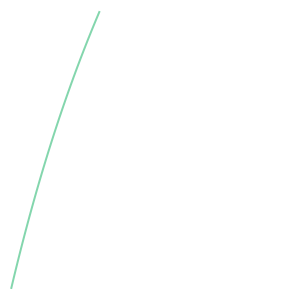

In [52]:
test

In [53]:
width = 10

In [54]:
test1 = test.parallel_offset(distance=width/2, side='right')

<Axes: >

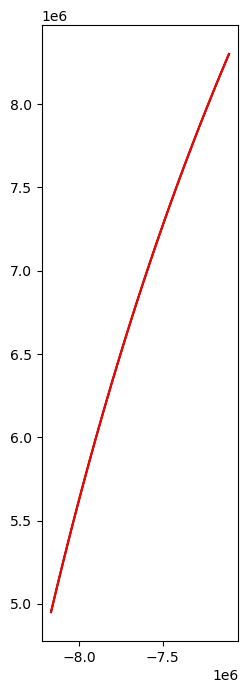

In [55]:
fig, ax = plt.subplots(figsize=(8,8))
gpd.GeoSeries(test).plot(ax=ax, color='k')
gpd.GeoSeries(test1).plot(ax=ax, color='r')